In [1]:
using CSV
using DataFrames
using Statistics

using Plots
using Plots.PlotMeasures
using StatsPlots, KernelDensity

using NCBITaxonomy

In [2]:
include("src/entropy.jl")

macro Name(arg)
    string(arg)
end


@Name (macro with 1 method)

In [3]:
taxondata = CSV.read("data/astralNR.id", DataFrame, header=1)

ids = []
lineages = []

for (id, taxid) in zip(taxondata.id, taxondata.taxid)
    try
        push!(lineages, lineage(taxon(taxid)))
        push!(ids, id) 
    catch
        println(id)
    end
end

domains = [taxid[3].name for taxid=lineages]
domaindata = DataFrame(id=ids, domain=domains)
df = dropmissing(domaindata)
e = "Eukaryota"
b = "Bacteria" 
a = "Archaea" 

"Archaea"

In [4]:
entropies = structure2fs3di("../scop40NR")
select!(entropies, Not([:coords]));
transform!(entropies, :id => ByRow(s -> first(split(s, "."))) => :id)
print()


In [21]:
col  =  1 # 1 = entropy, 2 = norm_entropy
entropies[!,:H_aa ]   = getindex.(shannon.(entropies.seqaa), col)
entropies[!,:H_aa2 ]  = getindex.(shannon.(entropies.seqaa, 2), col)
entropies[!,:H_aa3 ]  = getindex.(shannon.(entropies.seqaa, 3), col) 
entropies[!,:H_aa4 ]  = getindex.(shannon.(entropies.seqaa, 4), col)  
entropies[!,:H_aa5 ]  = getindex.(shannon.(entropies.seqaa, 5), col)  
entropies[!,:H_3Di ]  = getindex.(shannon.(entropies.seq3di), col)
entropies[!,:H_3Di2 ] = getindex.(shannon.(entropies.seq3di, 2), col)
entropies[!,:H_3Di3 ] = getindex.(shannon.(entropies.seq3di, 3), col)  
entropies[!,:H_3Di4 ] = getindex.(shannon.(entropies.seq3di, 4), col)  
entropies[!,:H_3Di5 ] = getindex.(shannon.(entropies.seq3di, 5), col)  
print()

In [22]:
fxdata = CSV.read("data/scop40_fs3_rmsd05.tsv", DataFrame, delim="\t", header=1)
df = innerjoin(fxdata, taxondata, domaindata, entropies, on=:id)
df = dropmissing(df)
df[!,:plen] = length.(df.seqaa)
df[!,:norm_plen] = (df.plen .- mean(df.plen)) / std(df.plen)
df[!, :norm_fxity] = df.fxity ./ length.(df.seqaa) 
df = df[!, [:ndx, :id, :scop, :domain, :taxid, :fxity, :norm_fxity, :nfrags, :plen, :norm_plen, :H_aa, :H_aa2, :H_aa3, :H_aa4, :H_aa5, :H_3Di, :H_3Di2, :H_3Di3, :H_3Di4, :H_3Di5, :seqaa, :seq3di]] 
size(df)


(3237, 22)

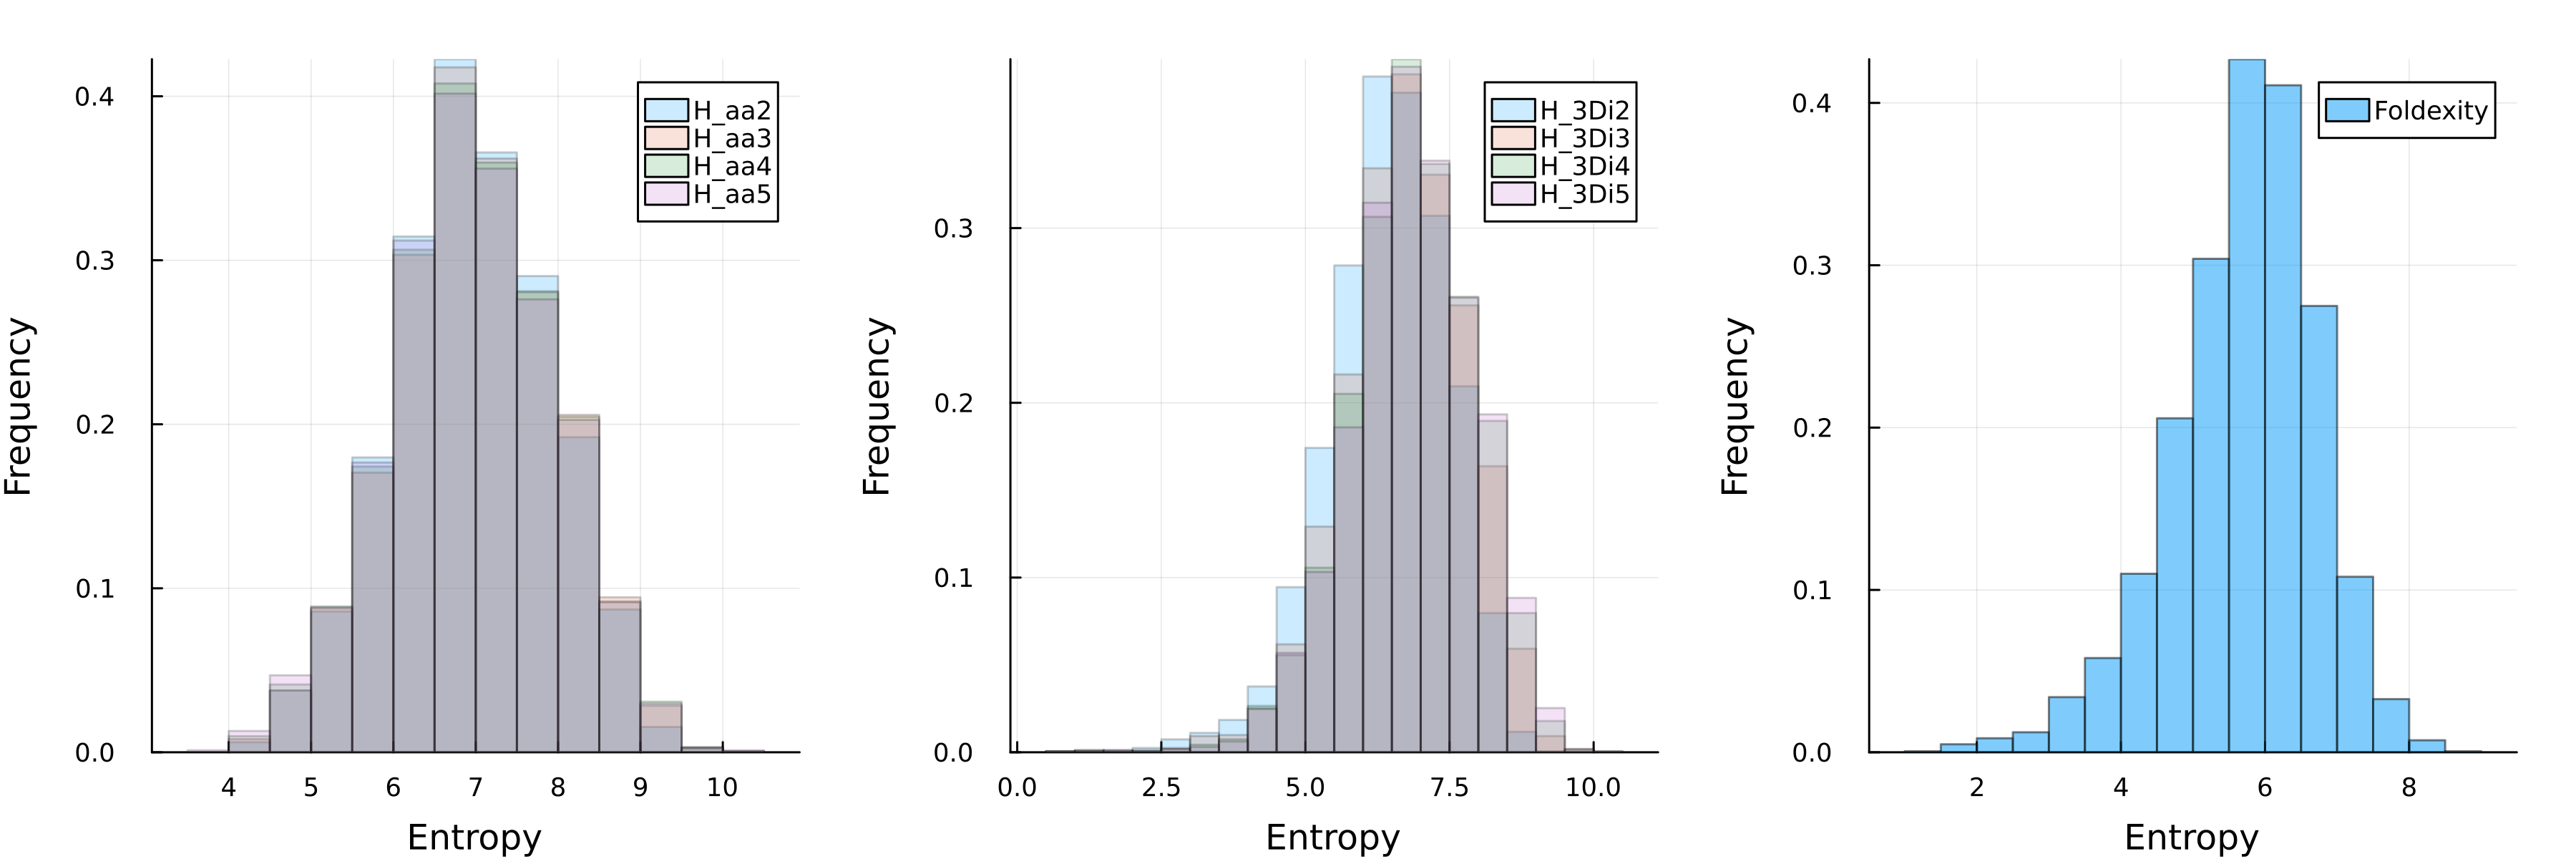

In [23]:
h1 = histogram([df[:, Haa] for Haa ∈ ("H_aa2", "H_aa3", "H_aa4", "H_aa5")], bins=25, xlabel="Entropy",  ylabel="Frequency", normalize=:pdf, labels=["H_aa2" "H_aa3" "H_aa4" "H_aa5"], alpha=0.2)
h2 = histogram([df[:, Haa] for Haa ∈ ("H_3Di2", "H_3Di3", "H_3Di4", "H_3Di5")], bins=25, xlabel="Entropy", ylabel="Frequency", normalize=:pdf, labels=["H_3Di2" "H_3Di3" "H_3Di4" "H_3Di5"], alpha=0.2)
h3 = histogram(df.fxity, bins=25, xlabel="Entropy", ylabel="Frequency", normalize=:pdf, label="Foldexity", alpha=0.5)
plot(h1, h2, h3, layout=(1, 3), size=(1200,400), dpi=300, margins = 5mm, )#xlimit = (2, 10), ytickfontsize=6, xtickfontsize=6)

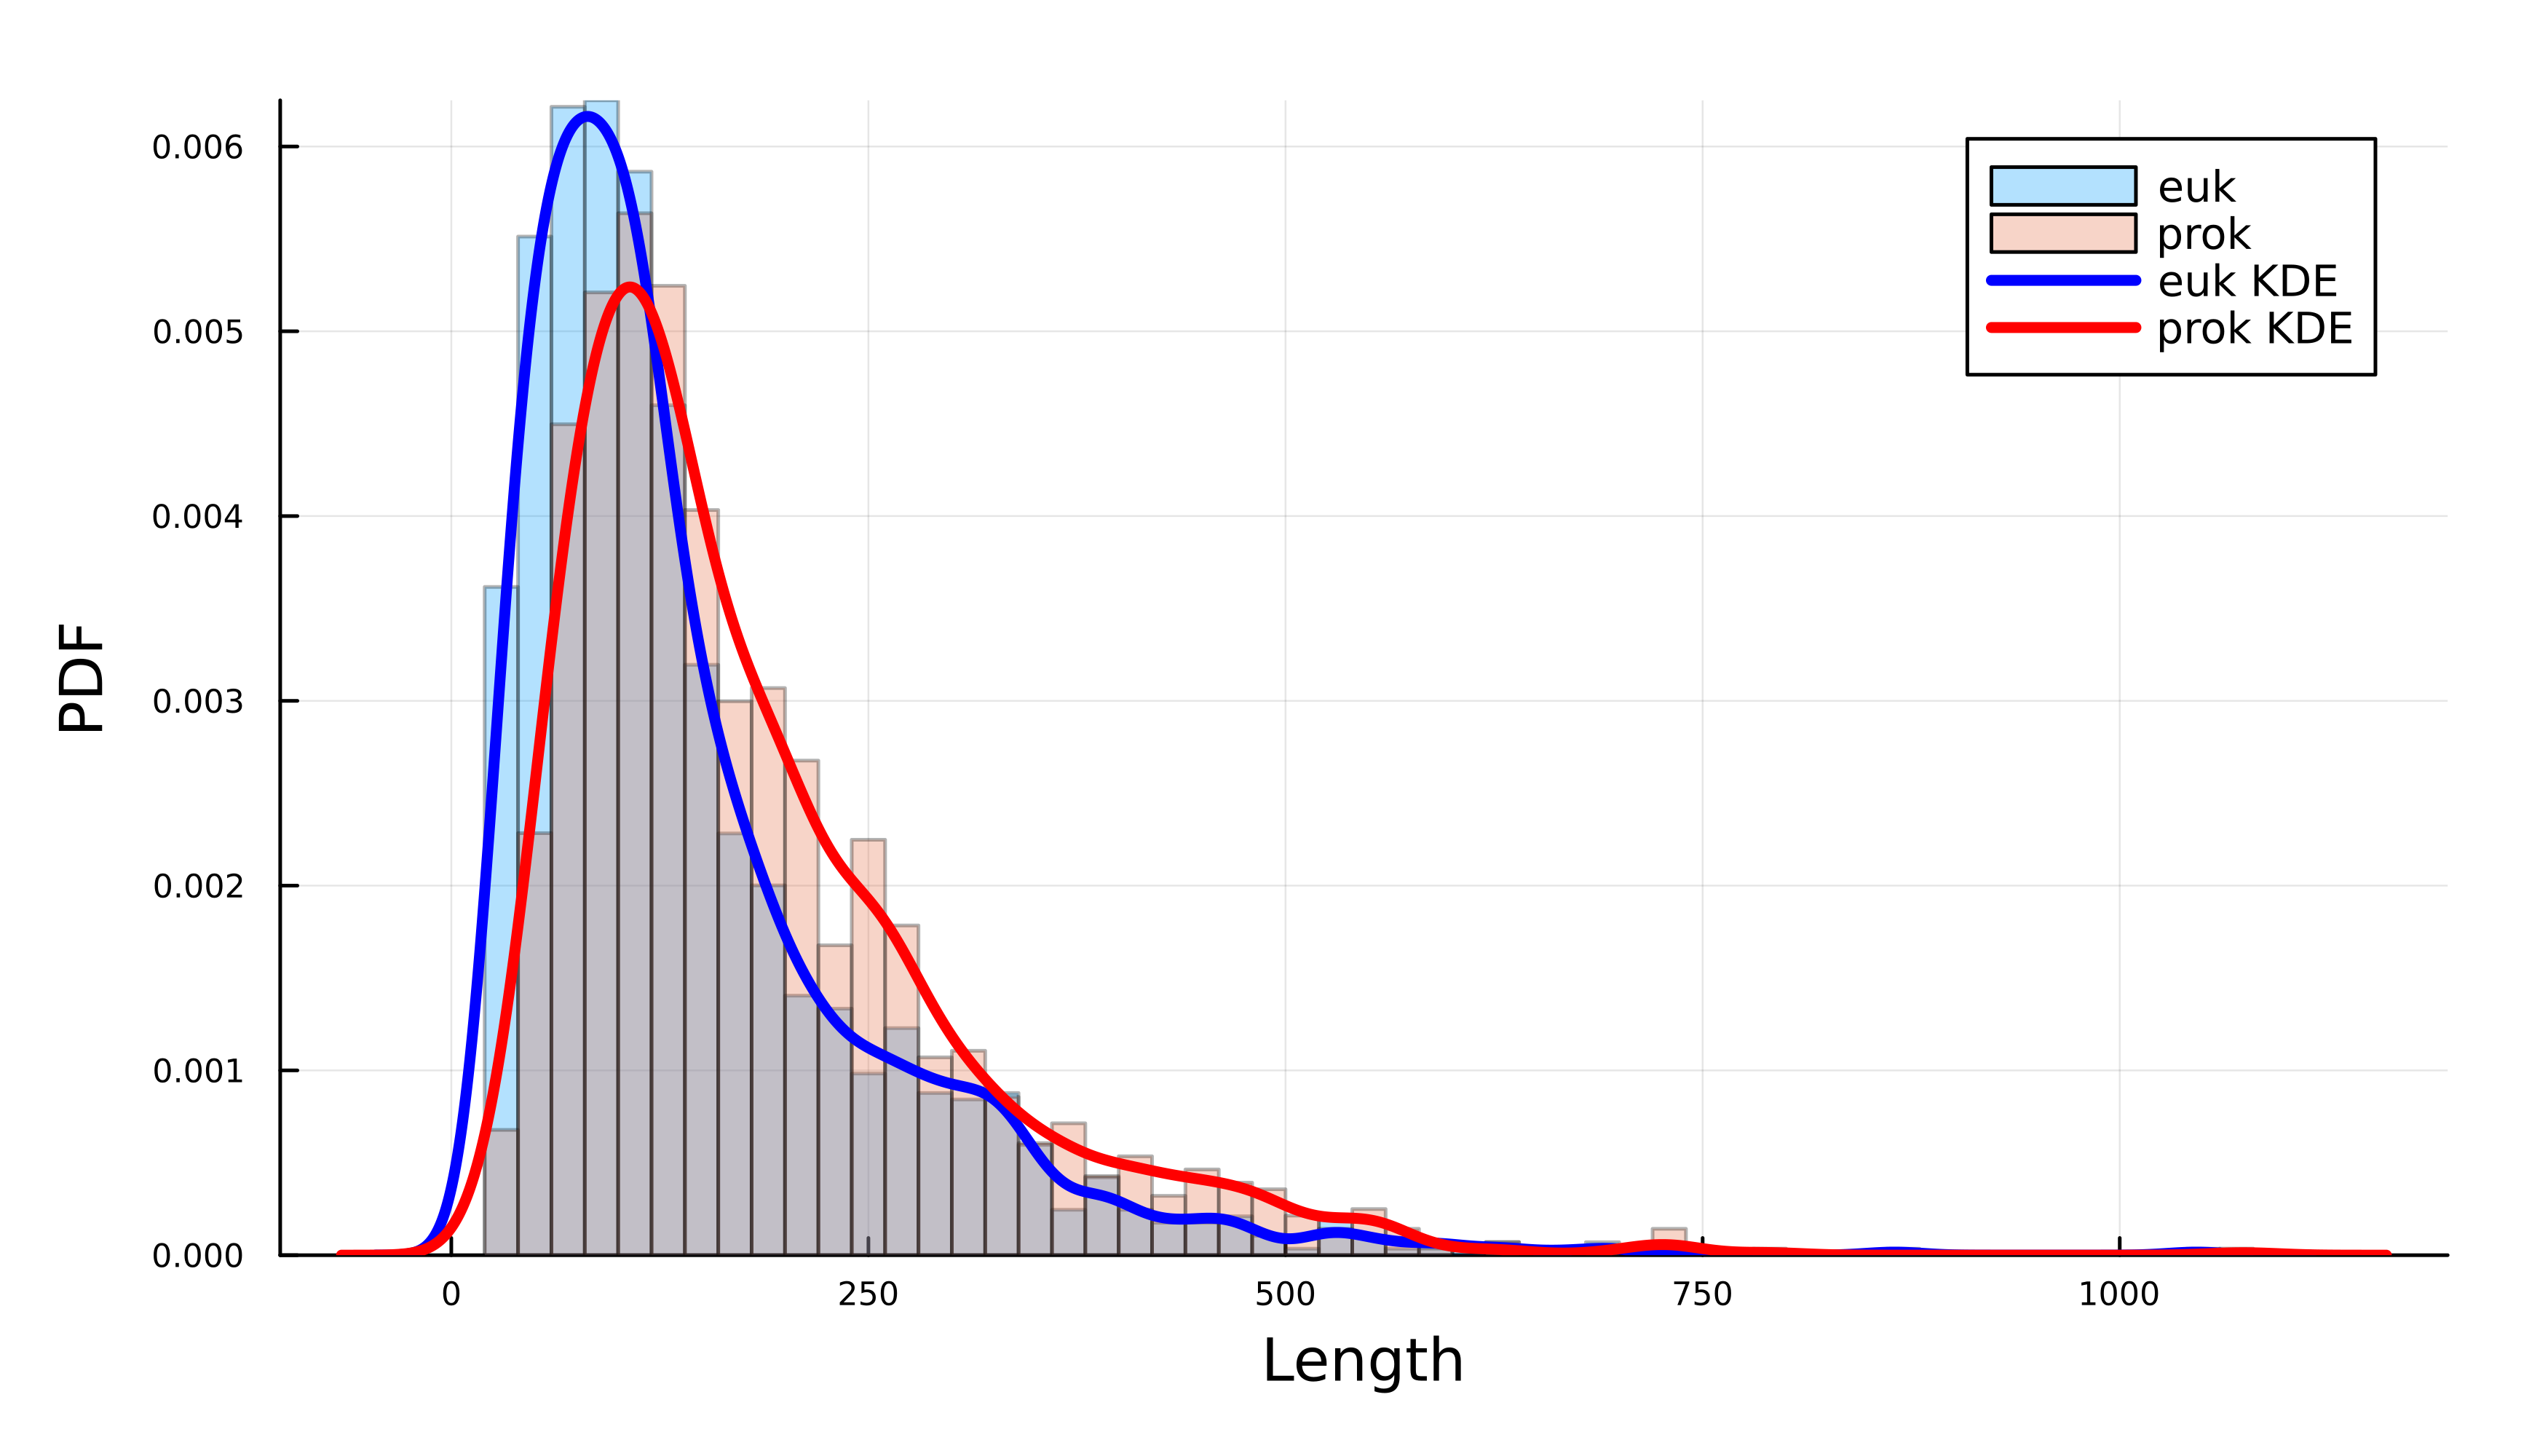

In [25]:
#df = df[(df.plen .> 80) .& (df.plen .< 120) ,:]

elen = df[(df.domain .== e),:].plen
blen = df[(df.domain .== b),:].plen

norm_elen = df[(df.domain .== e),:].norm_plen
norm_blen = df[(df.domain .== b),:].norm_plen



function lengthhistogram(elen, blen, name="")
    h1 = histogram(elen, bins=50, label="euk", alpha=0.3, normalize=:pdf,)
    h1 = histogram!(blen, bins=50,  label="prok", alpha=0.3, normalize=:pdf,xlabel=name, ylabel="PDF", legend=:topright)
    h1 = plot!(kde(elen).x, kde(elen).density, linewidth=3, label="euk KDE", color=:blue)
    h1 = plot!(kde(blen).x, kde(blen).density, linewidth=3, label="prok KDE", color=:red)
    return h1
end

h1=lengthhistogram(elen, blen, "Length")


plot(h1,  margins = 5mm, dpi=500, size=(700,400), xtickfontsize=6, ytickfontsize=6)

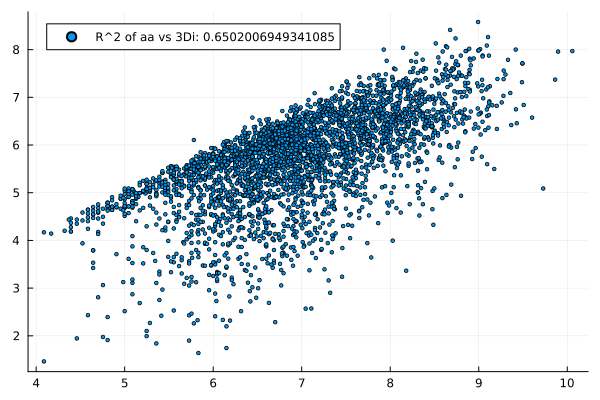

In [27]:
x = df.H_aa3
y = df.fxity
scatter(x, y, label="R^2 of aa vs 3Di: $(cor(x, y))", markershape=:circle, markersize = 2)


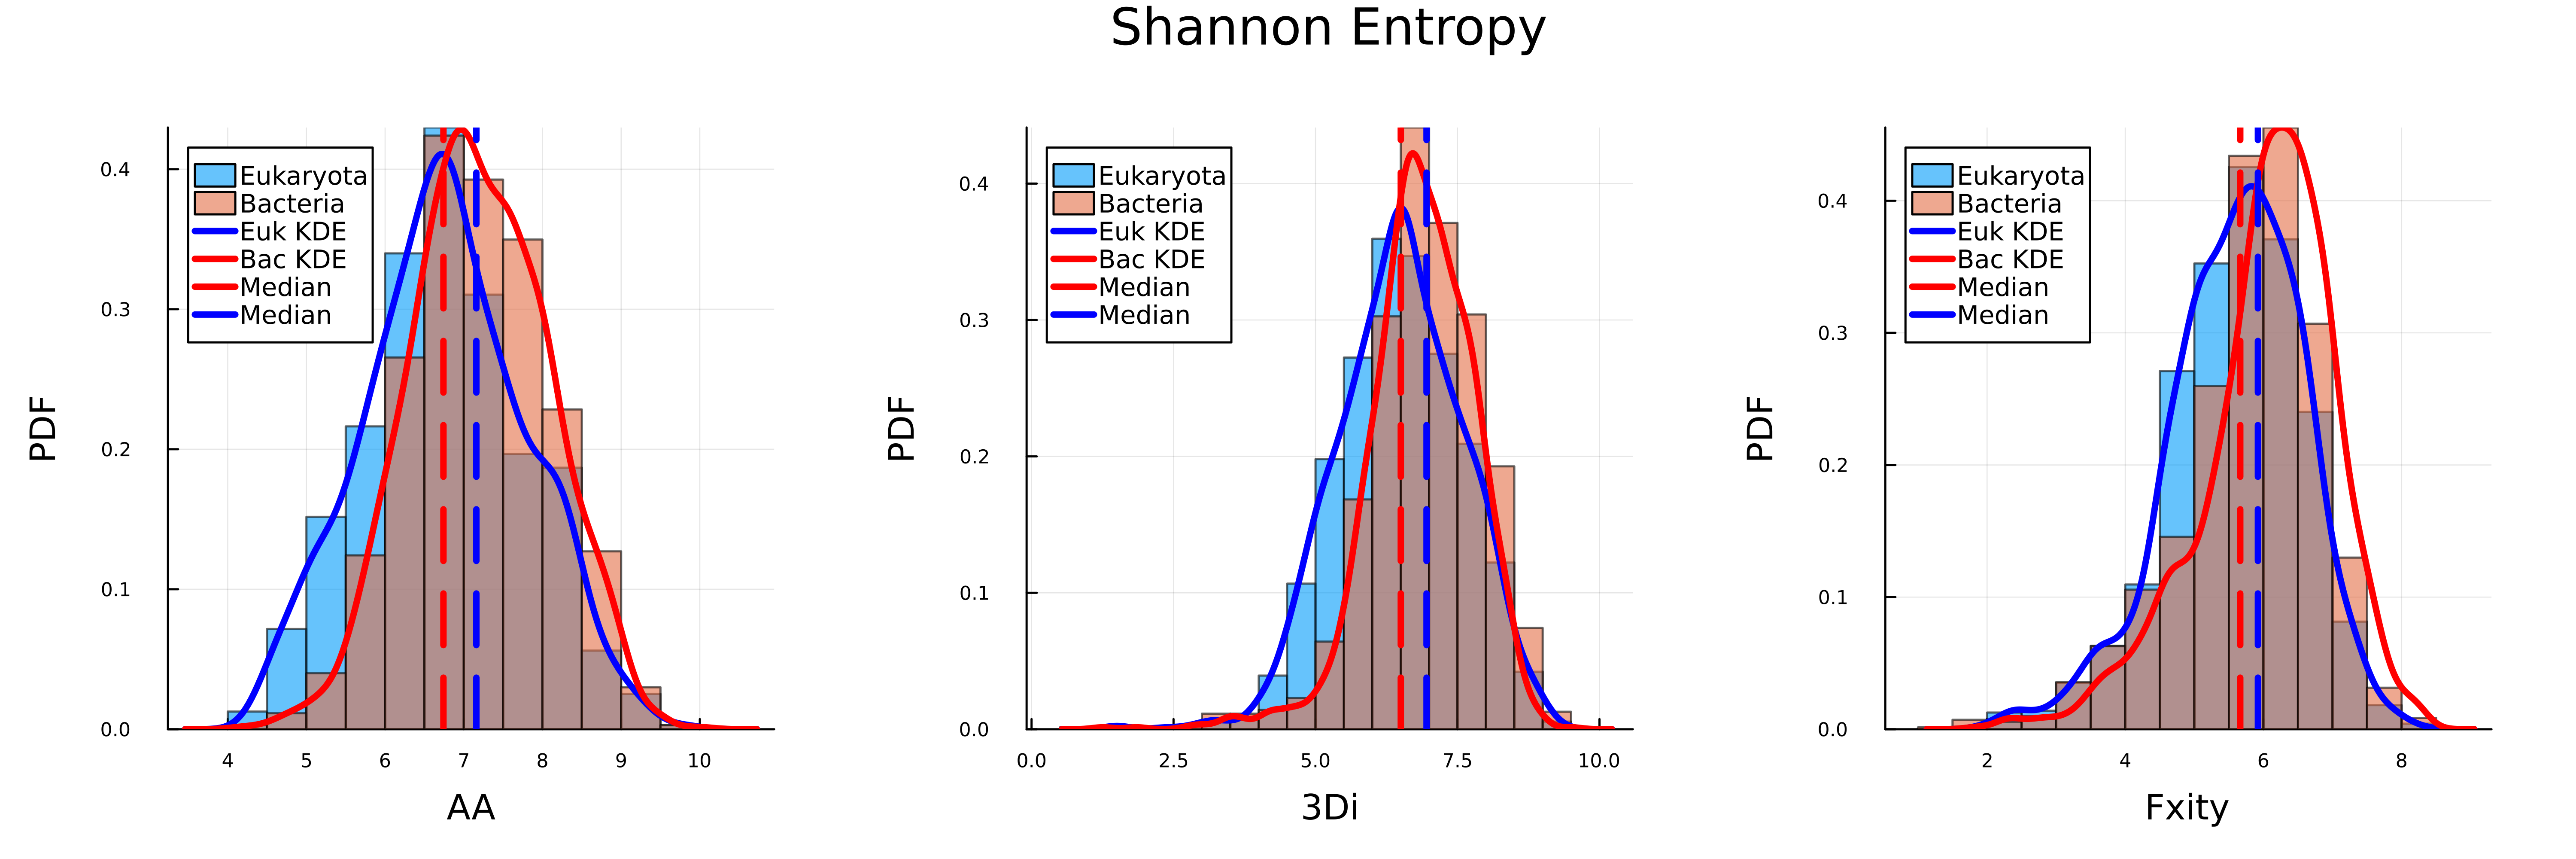

In [46]:
function entrohistogram(E, B, xname="")
    h = histogram([E, B], bins=20, alpha=0.6, normalize=:pdf, xlabel=xname, ylabel="PDF", label=["Eukaryota" "Bacteria"])
    h = plot!(kde(E).x, kde(E).density, linewidth=3, label="Euk KDE", color=:blue)
    h = plot!(kde(E).x, kde(B).density, linewidth=3, label="Bac KDE", color=:red)
    vline!(h, [median(E)], lw=3, color="red", label="Median", linestyle=:dash)
    vline!(h, [median(B)], lw=3, color="blue", label="Median", linestyle=:dash)
    return h
end

H_Eaa = df[df.domain .== e,:].H_aa3     #  ./ log10.(df[df.domain .== e,:].plen)
H_Baa = df[df.domain .== b,:].H_aa3     #  ./ log10.(df[df.domain .== b,:].plen)
H_E3Di = df[df.domain .== e,:].H_3Di3   #  ./ log10.(df[df.domain .== e,:].plen)
H_B3Di = df[df.domain .== b,:].H_3Di3   #  ./ log10.(df[df.domain .== b,:].plen)
H_Efx = df[df.domain .== e,:].fxity     #  ./ log10.(df[df.domain .== e,:].plen)
H_Bfx = df[df.domain .== b,:].fxity     #  ./ log10.(df[df.domain .== b,:].plen)


h1 = entrohistogram(H_Eaa, H_Baa, "AA")
h2 = entrohistogram(H_E3Di, H_B3Di, "3Di")
h3 = entrohistogram(H_Efx, H_Bfx, "Fxity")

plot(h1, h2, h3, layout=(1,3), margins = 8mm, dpi=500, size=(1200,400), #xscale=:log10, xlimit=(0.1, 1.),
    plot_title = "Shannon Entropy", xtickfontsize=6, ytickfontsize=6, legend=:topleft)

In [ ]:
for file in readdir("data")
    if endswith(file, ".tsv")

        df = CSV.read("data/$file", DataFrame, delim="\t", header=1)
        df[!, [:fxity, :aver_rmsd]] = round.(df[:,[:fxity, :aver_rmsd]], digits = 2)
        df = dropmissing(df)

        println("fxity vs nclusts: ", round(cor(df.fxity, df.nclusts), digits = 2),
        ";      fxity vs aver_rmsd: ", round(cor(df.fxity, df.aver_rmsd), digits = 2),
        ";      nclusts vs nfrags: ", round(cor(df.nclusts, df.nfrags), digits = 2),
        ";      nclusts vs aver_rmsd: ", round(cor(df.nclusts, df.aver_rmsd), digits = 2 )
        )

        p1 = histogram(df.fxity, bins=25,    xlabel="fxity", ylabel="Frequency", labels="")
        p2 = histogram(df.nclusts, bins=25,    xlabel="nclusts", ylabel="Frequency", labels="")
        p3 = histogram(df.aver_rmsd, bins=25,   xlabel="aver_rmsd", ylabel="Frequency", labels="")
        p4 = histogram(df.nfrags, bins=25,    xlabel="nfrags", ylabel="Frequency", labels="")

        p5 = scatter(df.fxity, df.nclusts,  xlabel="fxity", ylabel="nclusts", markershape=:circle, markersize = 3, labels="")
        p6 = scatter(df.fxity, df.aver_rmsd,  xlabel="fxity", ylabel="aver_rmsd", markershape=:circle, markersize = 3,labels="")
        p7 = scatter(df.nclusts, df.nfrags,  xlabel="nclusts", ylabel="nfrags", markershape=:circle, markersize = 3, labels="")
        p8 = scatter(df.nclusts, df.aver_rmsd,  xlabel="nclusts", ylabel="aver_rmsd", markershape=:circle, markersize = 3, labels="")

        plot(p1, p2, p3, p4, p5, p6, p7, p8, layout=(2, 4), margins = 5mm, dpi=300, xtickfontsize=6, ytickfontsize=6)
        plot!(size=(900,600))
        savefig("data/$(split(file,".")[1]).png")
    end
end

